# Homework 2: Infotaxis
Due April 16, 2025

## Preliminaries
A robot is moving on a 25x25 grid. At each time step the robot can move up, down, left, or right for one grid cell. There is an unknown signal source in the environment emitting signals. The robot is equipped with a binary sensor with a reading {0, 1}. The measurement model can be formulated as a Bernoulli distribution, and the likelihood of the Bernoulli distribution is specified based on the source location and the robot location.

<div style="text-align: center;">
  <img src="grid.png" alt="Grid" style="border-radius: 15px;">
</div>

The measurement model in the Infotaxis problem setup. Assuming the letter 'D' is where the signal source is, the shades and the numbers represent the likelihood of registering a sensor reading of '1' if the robot is in that region. The likelihood of registering a sensor reading of '0' is 1 - L(1)


In [159]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Use the GPU if available
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEV}")

Using device: cuda


## Robot Structure

```markdown
4 4 4 4 4 4 4
0 3 3 3 3 3 0
0 0 2 2 2 0 0
0 0 0 D 0 0 0
0 0 2 2 2 0 0
0 3 3 3 3 3 0
4 4 4 4 4 4 4
```

Where D is the signal source location and the number is the reciprocal of the likelihood of reading a 1 if the robot is in that region. For example: 3 -> (1/3) likelihood of 1 and (2/3) likelihood of reading 0.

In [160]:
# The likelihood function is "dumbbell" shaped
# The measurement model is specified over a discrete space
# Likelihood function for source location D
# Where number is reciprocal of likelihood of 1
# 4 -> 1/4 chance of 1, 3/4 chance of 0
# 4 4 4 4 4 4 4
# 0 3 3 3 3 3 0
# 0 0 2 2 2 0 0
# 0 0 0 D 0 0 0
# 0 0 2 2 2 0 0
# 0 3 3 3 3 3 0
# 4 4 4 4 4 4 4

# Grid constants and initialization
GRID_SIZE = 25
TOTAL_CELLS = GRID_SIZE * GRID_SIZE

X, Y = torch.meshgrid(
    torch.arange(GRID_SIZE, device=DEV),
    torch.arange(GRID_SIZE, device=DEV),
)

ACTIONS = torch.tensor(
    [
        [-1, 0],  # up
        [1, 0],  # down
        [0, -1],  # left
        [0, 1],  # right
        # [0, 0]  # stay
    ],
    device=DEV,
).float()


def in_bounds(x, y):
    return (0 <= x < GRID_SIZE) and (0 <= y < GRID_SIZE)


def random_robot_action(robot):
    a = torch.randint(0, len(ACTIONS), (1,), device=DEV).item()
    while True:
        action = ACTIONS[a]
        new_x = robot[0] + action[0]
        new_y = robot[1] + action[1]
        # Ensure the robot stays within the grid boundaries
        if in_bounds(new_x, new_y):
            break
        a = torch.randint(0, len(ACTIONS), (1,), device=DEV).item()
    return torch.tensor([int(new_x.item()), int(new_y.item())], device=DEV, dtype=torch.int64)

# Create a grid of likelihood values
source_likelihood = np.zeros((7, 7))
source_likelihood[3, 3] = 1.0  # Center point has the highest likelihood

for r in range(4):  # Iterate through the top half of the grid (including the middle row)
  for c in range(7):
    # Top and bottom rows are 1/4 chance of 1
    if r == 0: 
      source_likelihood[r, c] = 1 / 4.0
      source_likelihood[6 - r, c] = 1 / 4.0
    # Second row is 1/3 chance of 1
    elif r == 1 and (c != 0 and c != 6): 
      source_likelihood[r, c] = 1 / 3.0
      source_likelihood[6 - r, c] = 1 / 3.0
    # Third row is 1/2 chance of 1
    elif r == 2 and (c != 0 and c != 1 and c != 5 and c != 6):
      source_likelihood[r, c] = 1 / 2.0
      source_likelihood[6 - r, c] = 1 / 2.0
    # Center point has the highest likelihood
    elif r == 3 and c == 3:
      source_likelihood[r, c] = 1.0

source_likelihood = torch.tensor(source_likelihood, device=DEV)

# Overlay the source likelihood on the main grid to obtain the likelihood grid
def create_likelihood(source):
    # Overlay the source likelihood on the main grid at the given source location
    L = torch.ones((GRID_SIZE, GRID_SIZE), device=DEV)
    L *= 1 / TOTAL_CELLS  # Initialize with uniform distribution
    x, y = source[0], source[1]
    for r in range(7):
        for c in range(7):
            # Calculate the new coordinates based on the source location
            # Shift into top-left corner of 7x7 likelihood grid
            new_x = x - 3 + c
            new_y = y - 3 + r
            # Ensure the new coordinates are within bounds
            if in_bounds(new_x, new_y):
                L[new_y, new_x] = source_likelihood[r, c]
    # Normalize the likelihood grid
    L /= L.sum()
    return L

# LIKELIHOOD = create_likelihood(source=torch.tensor([10, 12], device=DEV))
# Print the likelihood grid
# print("Likelihood grid:")
# for row in LIKELIHOOD.cpu().numpy():
#     print(" ".join(f"{val:.2f}" for val in row))
    
def simulate_measurement(x, y, L):
    # Simulate a measurement at the given (x, y) location
    # The measurement is 1 with probability equal to the likelihood at that location
    likelihood = L[y, x].item()
    measurement = torch.tensor(1 if torch.rand(1).item() < likelihood else 0, device=DEV)
    return measurement
  
def bayesian_update(L, measurement, robot):
    # Perform a Bayesian update on the likelihood grid based on the measurement
    # Update the likelihood grid based on the measurement
    if measurement == 1:
        L *= create_likelihood(robot)
    else:
        L *= (1 - create_likelihood(robot))

    # Normalize the likelihood grid
    L /= L.sum()
    return L

## Problem 1: Exploration Strategy

Source Location: [17 16]
Initial Robot Location: [ 3 19]
Final Robot Location: [ 5 18]


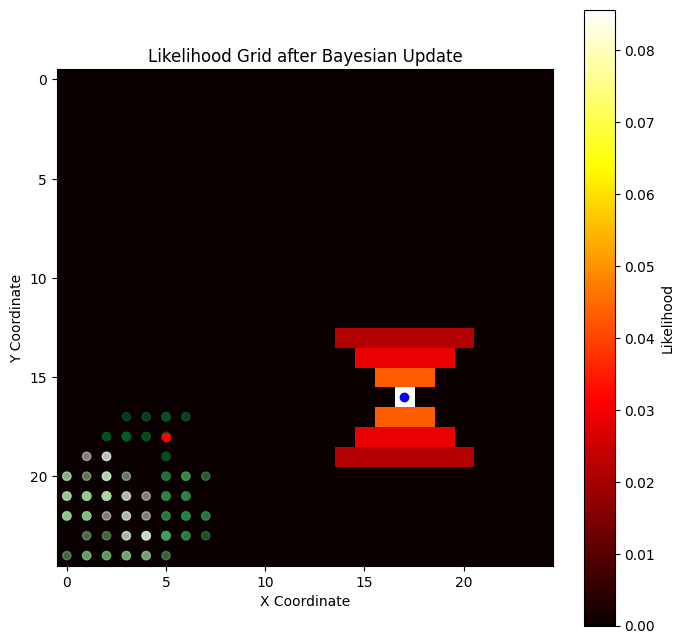

In [161]:
# Randomly sample a source location and an initial location of the robot.
source_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
robot_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
print(f"Source Location: {source_location.cpu().numpy()}")
print(f"Initial Robot Location: {robot_location.cpu().numpy()}")

NUM_TIMESTEPS = 100

# Develop an exploration strategy, at each time step, 
# select an action (up,down, left, right, stay) to quickly explore the search space
# Move the robot according to the selected action
robot_path = [robot_location.cpu().numpy()]
L = create_likelihood(source_location)
for t in range(1, NUM_TIMESTEPS):
    # Randomly select an action for the robot
    robot_location = random_robot_action(robot_location)
    robot_path.append(robot_location.cpu().numpy())
    # print(f"Robot moved to: {robot_location.cpu().numpy()} at time {t}")

    # After executing each action, simulate a measurement, 
    # and use Bayesian update to update the belief of the source location.
    x, y = robot_location[0].item(), robot_location[1].item()
    Z = simulate_measurement(x, y, L)
    L = bayesian_update(L, Z, robot_location)

print(f"Final Robot Location: {robot_location.cpu().numpy()}")
robot_path_np = np.array(robot_path)

# Visualize the likelihood grid with heatmap
plt.figure(figsize=(8, 8))
plt.imshow(L.cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar(label='Likelihood')
plt.scatter(source_location[0].cpu().numpy(), source_location[1].cpu().numpy(), c='blue', label='Source Location')
plt.scatter(robot_path_np[1:, 0], robot_path_np[1:, 1], c=np.linspace(0, 1, len(robot_path_np[1:])), cmap='Greens', label='Robot Path', alpha=0.5)
# plt.scatter(robot_path[0][1], robot_path[0][0], c='cyan', label='Initial Robot Location')
plt.scatter(robot_location[0].cpu().numpy(), robot_location[1].cpu().numpy(), c='red', label='Final Robot Location')
plt.title('Likelihood Grid after Bayesian Update')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
# plt.legend()
plt.grid(False)
plt.savefig("problem_1.png")

## Problem 2: Infotaxis Algorithm